In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler


In [2]:
#Read csv file to dataframe
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("gs://6893proj/crash_weather.csv", inferSchema=True, header=True)

df.show(1)

+-------------+--------+--------+---------+---------+--------------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------+--------------------+----------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+-------------------+-----------------+--------------+-----------------+
|    simp_date| borough|zip code| latitude|longitude|            location|     off street name|number of persons injured|number of persons killed|number of pedestrians injured|number of pedestrians killed|number of cyclist injured|number of cyclist killed|number of motorist injured|number of motorist killed|collision_id|                date|            time|temperature_2m (°C)|precipitation (mm)|rain

In [3]:
df1 = df.select("simp_date", "latitude", "longitude", "borough")
df1.show(3)

+-------------+---------+---------+--------+
|    simp_date| latitude|longitude| borough|
+-------------+---------+---------+--------+
|2021-09-11 09|40.667202| -73.8665|BROOKLYN|
|2021-12-14 08| 40.86816|-73.83148|   BRONX|
|2021-12-14 21| 40.67172| -73.8971|BROOKLYN|
+-------------+---------+---------+--------+
only showing top 3 rows



In [4]:
df1 = df1.withColumn('month', split(df['simp_date'], '-').getItem(1))
df1 = df1.drop('simp_date')
df1.show(truncate=False)
df1.printSchema()

+------------------+----------+-------------+-----+
|latitude          |longitude |borough      |month|
+------------------+----------+-------------+-----+
|40.667202         |-73.8665  |BROOKLYN     |09   |
|40.86816          |-73.83148 |BRONX        |12   |
|40.67172          |-73.8971  |BROOKLYN     |12   |
|40.75144          |-73.97397 |MANHATTAN    |12   |
|40.675883999999996|-73.75577 |QUEENS       |12   |
|40.66684          |-73.78941 |QUEENS       |12   |
|40.68158          |-73.97463 |BROOKLYN     |12   |
|40.65068          |-73.95881 |BROOKLYN     |12   |
|40.87262          |-73.904686|BRONX        |12   |
|40.748917         |-73.993546|MANHATTAN    |12   |
|40.75373          |-73.88505 |QUEENS       |12   |
|40.63165          |-74.08762 |STATEN ISLAND|12   |
|40.623104         |-73.95809 |BROOKLYN     |12   |
|40.66576          |-73.9845  |BROOKLYN     |12   |
|40.687534         |-73.9775  |BROOKLYN     |12   |
|40.710957         |-73.951126|BROOKLYN     |12   |
|40.81813   

### MANHATTAN_spring

In [5]:
spring = df1.rdd.filter(lambda x: x[3]=='03' or x[3]=='04' or x[3]=='05')
spring = spring.filter(lambda x: x[2]=="MANHATTAN")
spring = spring.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
spring = spring.map(lambda x: [x[0], x[1]])

loc_spring = spring.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_spring)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|40.767242|-73.986206|[40.767242,-73.98...|
|40.748158| -73.97033|[40.748158,-73.97...|
|40.797836| -73.96946|[40.797836,-73.96...|
| 40.75632|-73.999275|[40.75632,-73.999...|
|40.761486| -73.96061|[40.761486,-73.96...|
|40.833786| -73.94037|[40.833786,-73.94...|
| 40.72224|  -73.9863| [40.72224,-73.9863]|
|40.730145| -73.99781|[40.730145,-73.99...|
|40.778805|-73.974075|[40.778805,-73.97...|
|40.747894|-73.989174|[40.747894,-73.98...|
|40.754707| -73.99164|[40.754707,-73.99...|
|40.798286|-73.938705|[40.798286,-73.93...|
|40.799484| -73.92929|[40.799484,-73.92...|
|40.766502| -73.99418|[40.766502,-73.99...|
| 40.79335| -73.97275|[40.79335,-73.97275]|
| 40.72538| -74.00011|[40.72538,-74.00011]|
|40.841717| -73.94435|[40.841717,-73.94...|
|40.760822| -73.99832|[40.760822,-73.99...|
| 40.74608|-73.974945|[40.74608,-73.974...|
|40.767967| -73.96822|[40.767967

In [6]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
|40.767242|-73.986206|[40.767242,-73.98...|        15|
|40.748158| -73.97033|[40.748158,-73.97...|        14|
|40.797836| -73.96946|[40.797836,-73.96...|        18|
| 40.75632|-73.999275|[40.75632,-73.999...|         6|
|40.761486| -73.96061|[40.761486,-73.96...|        10|
|40.833786| -73.94037|[40.833786,-73.94...|        19|
| 40.72224|  -73.9863| [40.72224,-73.9863]|         4|
|40.730145| -73.99781|[40.730145,-73.99...|        17|
|40.778805|-73.974075|[40.778805,-73.97...|         8|
|40.747894|-73.989174|[40.747894,-73.98...|         0|
|40.754707| -73.99164|[40.754707,-73.99...|         6|
|40.798286|-73.938705|[40.798286,-73.93...|        12|
|40.799484| -73.92929|[40.799484,-73.92...|        12|
|40.766502| -73.99418|[40.766502,-73.99...|        15|
| 40.79335| -73.97275|[40.79335,-73.97275]|        18|
| 40.72538

In [7]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.74462298 -73.99131537]
[ 40.8454208  -73.93741442]
[ 40.80911447 -73.95264149]
[ 40.77447326 -73.95612844]
[ 40.71959777 -73.99098448]
[ 40.8642356  -73.92196362]
[ 40.75570493 -73.99648378]
[ 40.70431217 -73.81189308]
[ 40.77977622 -73.97945524]
[ 40.75892043 -73.97325039]
[ 40.7625452  -73.96362915]
[ 40.73223977 -73.98348067]
[ 40.80239079 -73.93795887]
[ 40.71461537 -74.00682841]
[ 40.74751809 -73.97850273]
[ 40.76258266 -73.98632132]
[ 40.7883438  -73.94750717]
[ 40.73700765 -74.00319864]
[ 40.79528677 -73.96895064]
[ 40.82420445 -73.94305759]


Text(0.5,1,'MANHATTAN_spring')

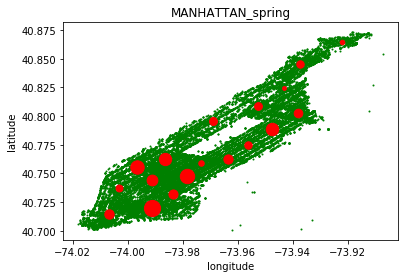

In [8]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/200)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_spring")

### MANHATTAN_summer

In [9]:
summer = df1.rdd.filter(lambda x: x[3]=='06' or x[3]=='07' or x[3]=='08')
summer = summer.filter(lambda x: x[2]=="MANHATTAN")
summer = summer.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
summer = summer.map(lambda x: [x[0], x[1]])

loc_summer = summer.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_summer)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|40.730446| -74.00431|[40.730446,-74.00...|
|40.806713| -73.93782|[40.806713,-73.93...|
|40.718792| -73.98902|[40.718792,-73.98...|
| 40.82324|-73.938835|[40.82324,-73.938...|
|40.798584| -73.93353|[40.798584,-73.93...|
| 40.80153| -73.93669|[40.80153,-73.93669]|
|40.721474| -73.98383|[40.721474,-73.98...|
| 40.83978| -73.94322|[40.83978,-73.94322]|
| 40.81084| -73.95068|[40.81084,-73.95068]|
|40.770065|-73.949394|[40.770065,-73.94...|
|40.841152|-73.942696|[40.841152,-73.94...|
| 40.75545|-73.962105|[40.75545,-73.962...|
| 40.80574|-73.942764|[40.80574,-73.942...|
| 40.80576| -73.94868|[40.80576,-73.94868]|
|40.703598|  -74.0144|[40.703598,-74.0144]|
| 40.74347| -74.00724|[40.74347,-74.00724]|
| 40.85206|-73.934784|[40.85206,-73.934...|
|40.734974|-74.000145|[40.734974,-74.00...|
|40.761036| -73.98702|[40.761036,-73.98...|
|40.729324| -73.99191|[40.729324

In [10]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
|40.730446| -74.00431|[40.730446,-74.00...|         3|
|40.806713| -73.93782|[40.806713,-73.93...|         1|
|40.718792| -73.98902|[40.718792,-73.98...|        11|
| 40.82324|-73.938835|[40.82324,-73.938...|        12|
|40.798584| -73.93353|[40.798584,-73.93...|         1|
| 40.80153| -73.93669|[40.80153,-73.93669]|         1|
|40.721474| -73.98383|[40.721474,-73.98...|        11|
| 40.83978| -73.94322|[40.83978,-73.94322]|        18|
| 40.81084| -73.95068|[40.81084,-73.95068]|         7|
|40.770065|-73.949394|[40.770065,-73.94...|         6|
|40.841152|-73.942696|[40.841152,-73.94...|        18|
| 40.75545|-73.962105|[40.75545,-73.962...|         0|
| 40.80574|-73.942764|[40.80574,-73.942...|         1|
| 40.80576| -73.94868|[40.80576,-73.94868]|         7|
|40.703598|  -74.0144|[40.703598,-74.0144]|        10|
| 40.74347

In [11]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.76305701 -73.96413163]
[ 40.79981231 -73.93934965]
[ 40.75029909 -73.97544135]
[ 40.72420003 -74.00459974]
[ 40.86482389 -73.9222879 ]
[ 40.84832332 -73.93530786]
[ 40.78075518 -73.95222536]
[ 40.80835418 -73.95333878]
[ 40.73633643 -73.98515854]
[ 40.76359605 -73.98311418]
[ 40.70978853 -74.00980562]
[ 40.7206908  -73.98421618]
[ 40.81875318 -73.94289921]
[ 40.77986238 -73.97949517]
[ 40.75844185 -73.99550722]
[ 40.71913676 -73.9951169 ]
[ 40.74275547 -74.00110822]
[ 40.7502849  -73.98858436]
[ 40.83439606 -73.94272245]
[ 40.79478586 -73.96896385]


Text(0.5,1,'MANHATTAN_summer')

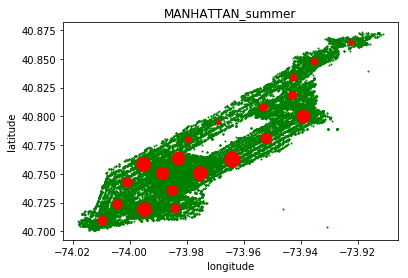

In [12]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = summer.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/200)
            idx+=1

plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_summer")

### MANHATTAN_fall

In [13]:
fall = df1.rdd.filter(lambda x: x[3]=='09' or x[3]=='10' or x[3]=='11')
fall = fall.filter(lambda x: x[2]=="MANHATTAN")
fall = fall.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
fall = fall.map(lambda x: [x[0], x[1]])

loc_fall = fall.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_fall)
new_df.show()

+---------+------------------+--------------------+
| latitude|         longitude|            features|
+---------+------------------+--------------------+
|40.746395|          -73.9856|[40.746395,-73.9856]|
|40.718662|         -74.00615|[40.718662,-74.00...|
|40.724846|           -73.999| [40.724846,-73.999]|
|40.781315|         -73.94614|[40.781315,-73.94...|
|40.751442|         -73.97606|[40.751442,-73.97...|
|40.797924|          -73.9296|[40.797924,-73.9296]|
|40.802982|         -73.93815|[40.802982,-73.93...|
|40.715477|        -73.998085|[40.715477,-73.99...|
| 40.82207|         -73.94993|[40.82207,-73.94993]|
|40.812912|-73.95364000000001|[40.812912,-73.95...|
| 40.79194|         -73.95281|[40.79194,-73.95281]|
| 40.79184|         -73.93556|[40.79184,-73.93556]|
|40.710697|        -73.984634|[40.710697,-73.98...|
|40.762966|        -73.973976|[40.762966,-73.97...|
|40.779602|         -73.95553|[40.779602,-73.95...|
| 40.80609|         -73.95414|[40.80609,-73.95414]|
| 40.76649| 

In [14]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+------------------+--------------------+----------+
| latitude|         longitude|            features|prediction|
+---------+------------------+--------------------+----------+
|40.746395|          -73.9856|[40.746395,-73.9856]|        12|
|40.718662|         -74.00615|[40.718662,-74.00...|        16|
|40.724846|           -73.999| [40.724846,-73.999]|        16|
|40.781315|         -73.94614|[40.781315,-73.94...|         0|
|40.751442|         -73.97606|[40.751442,-73.97...|         8|
|40.797924|          -73.9296|[40.797924,-73.9296]|         6|
|40.802982|         -73.93815|[40.802982,-73.93...|         6|
|40.715477|        -73.998085|[40.715477,-73.99...|        16|
| 40.82207|         -73.94993|[40.82207,-73.94993]|         3|
|40.812912|-73.95364000000001|[40.812912,-73.95...|        14|
| 40.79194|         -73.95281|[40.79194,-73.95281]|         0|
| 40.79184|         -73.93556|[40.79184,-73.93556]|         6|
|40.710697|        -73.984634|[40.710697,-73.98...|    

In [15]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.78708965 -73.94819294]
[ 40.74315887 -74.00180479]
[ 40.71941086 -73.98885955]
[ 40.82630166 -73.94297396]
[ 40.75840037 -73.99464099]
[ 40.8639608  -73.92272854]
[ 40.80189763 -73.93785599]
[ 40.80114071 -73.96140717]
[ 40.74827668 -73.97610473]
[ 40.73458385 -73.98496415]
[ 40.71003138 -74.00957616]
[ 40.77318022 -73.95671577]
[ 40.7479218  -73.98976452]
[ 40.76131316 -73.96636484]
[ 40.81180993 -73.95004726]
[ 40.76010806 -73.9814881 ]
[ 40.72183726 -74.0018168 ]
[ 40.84565346 -73.93726836]
[ 40.78699113 -73.97489402]
[ 40.77186619 -73.98459072]


Text(0.5,1,'MANHATTAN_fall')

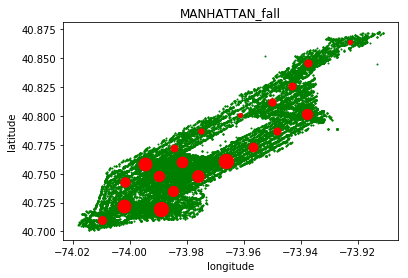

In [16]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = fall.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/200)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_fall")

### MANHATTAN_winter

In [17]:
winter = df1.rdd.filter(lambda x: x[3]=='12' or x[3]=='01' or x[3]=='02')
winter = winter.filter(lambda x: x[2]=="MANHATTAN")
winter = winter.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
winter = winter.map(lambda x: [x[0], x[1]])

loc_winter = winter.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_winter)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
| 40.75144| -73.97397|[40.75144,-73.97397]|
|40.748917|-73.993546|[40.748917,-73.99...|
|40.776237|-73.943825|[40.776237,-73.94...|
| 40.76175| -73.96899|[40.76175,-73.96899]|
|40.736614|  -73.9951|[40.736614,-73.9951]|
|40.813885| -73.95211|[40.813885,-73.95...|
| 40.77733| -73.95456|[40.77733,-73.95456]|
| 40.76551| -73.97795|[40.76551,-73.97795]|
|40.719055| -74.01245|[40.719055,-74.01...|
|40.752808| -73.99098|[40.752808,-73.99...|
| 40.76979|-73.988075|[40.76979,-73.988...|
| 40.84812| -73.92971|[40.84812,-73.92971]|
|40.774227| -73.98112|[40.774227,-73.98...|
| 40.83112|  -73.9419| [40.83112,-73.9419]|
|40.745384| -73.99471|[40.745384,-73.99...|
|40.747078|-73.981346|[40.747078,-73.98...|
| 40.72261| -73.99242|[40.72261,-73.99242]|
|40.720375|-74.003265|[40.720375,-74.00...|
|40.788357| -73.97453|[40.788357,-73.97...|
| 40.75524| -73.97328|[40.75524,

In [18]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
| 40.75144| -73.97397|[40.75144,-73.97397]|        15|
|40.748917|-73.993546|[40.748917,-73.99...|        14|
|40.776237|-73.943825|[40.776237,-73.94...|        10|
| 40.76175| -73.96899|[40.76175,-73.96899]|        17|
|40.736614|  -73.9951|[40.736614,-73.9951]|         0|
|40.813885| -73.95211|[40.813885,-73.95...|        13|
| 40.77733| -73.95456|[40.77733,-73.95456]|        10|
| 40.76551| -73.97795|[40.76551,-73.97795]|         3|
|40.719055| -74.01245|[40.719055,-74.01...|        12|
|40.752808| -73.99098|[40.752808,-73.99...|        11|
| 40.76979|-73.988075|[40.76979,-73.988...|         3|
| 40.84812| -73.92971|[40.84812,-73.92971]|         4|
|40.774227| -73.98112|[40.774227,-73.98...|         7|
| 40.83112|  -73.9419| [40.83112,-73.9419]|         5|
|40.745384| -73.99471|[40.745384,-73.99...|        14|
|40.747078

In [19]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.73659687 -73.98580305]
[ 40.80122493 -73.93851663]
[ 40.73154228 -74.00295395]
[ 40.76523013 -73.98430208]
[ 40.84446342 -73.93789983]
[ 40.8239917 -73.9430732]
[ 40.7674997  -73.95976949]
[ 40.78110599 -73.97853388]
[ 40.70858741 -74.01017702]
[ 40.72066856 -73.98411419]
[ 40.78335521 -73.95034315]
[ 40.75608188 -73.99261025]
[ 40.71904417 -74.00539165]
[ 40.80935244 -73.95220336]
[ 40.74517568 -73.99915715]
[ 40.74830235 -73.97806969]
[ 40.86385928 -73.92280829]
[ 40.75950225 -73.96983167]
[ 40.71951212 -73.99479692]
[ 40.79576604 -73.96843826]


Text(0.5,1,'MANHATTAN_winter')

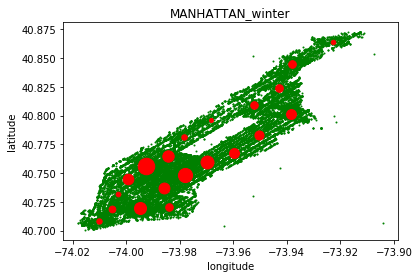

In [20]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = winter.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.9:
        if i[0]>40.70 and i[0]<40.90:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if j[1]>-74.05 and j[1]<-73.9:
        if j[0]>40.70 and j[0]<40.90:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/200)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("MANHATTAN_winter")